# Understanding Diffusion

---

# Building Diffusion Systems with Diffusers

The `diffusers` library is designed to be a user-friendly and flexible toolbox for building diffusion systems tailored to your use-case. At the core of this toolbox are **models** and **schedulers**. While the `DiffusionPipeline` bundles these components together for convenience, you can also unbundle the pipeline and use the models and schedulers separately to create new diffusion systems.

# Understanding Diffusion

---

## Diffusion Models: A Deep Dive

Diffusion models are an exciting advancement in the field of generative models. The high-level idea is simple yet powerful: these models take images that are blurred with noise and learn to denoise them, resulting in clear images. During training, the model sees images with varying levels of noise, and at inference time, it starts with pure noise and iteratively generates an image that looks like it came from the training data.

### The Key Insight: Iterative Refinement

So, what makes diffusion models so effective? Unlike previous techniques like Variational Autoencoders (VAEs) or Generative Adversarial Networks (GANs), which generate images in a single pass, diffusion models create images through many steps. This iterative process allows the model to refine and correct its output gradually, leading to high-quality image generation. To see this in action, let's explore an example using the Hugging Face diffusers library.

### Loading a Pre-Trained Diffusion Model

We'll use the `DDPMPipeline` from the Hugging Face diffusers library to load a pre-trained diffusion model. Specifically, we'll use the `ddpm-celebahq-256` model, which was trained on the CelebA-HQ dataset—a collection of high-quality celebrity images. This model will generate images resembling those in the dataset, starting from pure noise.

In this tutorial, you’ll learn how to use models and schedulers to assemble a diffusion system for inference. We'll start with a basic pipeline and then progress to the more complex Stable Diffusion pipeline.

## Deconstruct a Basic Pipeline

A pipeline is a quick and easy way to run a model for inference, requiring no more than four lines of code to generate an image:

In [1]:
!pip install diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 26.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [2]:
from diffusers import DDPMPipeline

# DDPMPipeline = Denoising Diffusion Probabilistic Models
# https://huggingface.co/docs/diffusers/v0.3.0/en/api/pipelines/ddpm
# This is the base class which can contain diffusion models
# and we can load them simply passing the model string to from_pretrained()
# Usually, they have two components:
# - model, unet: the UNet model which performs the denoising
# - scheduler: which runs the unet in several steps
# Here, both components are used behing the hood
# but we can use them separately, as shown below.
# However, usually we don't use them separately.
ddpm = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/30 [00:00<?, ?it/s]

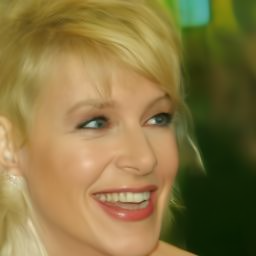

In [4]:
# We run the model using the schedulerin 30 steps
image = ddpm(num_inference_steps=30).images[0]
# Display
image

This generates an image of a fake celebrity using the `DDPMPipeline`. But how does it work under the hood? Let’s break down the pipeline and see what’s happening.

### Understanding the Pipeline

In the example above, the pipeline contains a `UNet2DModel` model and a `DDPMScheduler`. The pipeline denoises an image by taking random noise the size of the desired output and passing it through the model several times. At each timestep, the model predicts the noise residual and the scheduler uses it to predict a less noisy image. This process repeats until it reaches the end of the specified number of inference steps.

To recreate the pipeline with the model and scheduler separately, let’s write our own denoising process.

### Load the Model and Scheduler

First, we need to load the model and scheduler:

In [5]:
from diffusers import DDPMScheduler, UNet2DModel

# Instead of using DDPMPipeline,
# we now will use th emodel and the scheduler separately
scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")
model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to("cuda")


An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


### Set the Number of Timesteps

Next, we set the number of timesteps to run the denoising process for:

In [ ]:
# Create 50 evenly spaced timesteps
scheduler.set_timesteps(50)


Setting the scheduler timesteps creates a tensor with evenly spaced elements, 50 in this example. Each element corresponds to a timestep at which the model denoises an image:

In [7]:

scheduler.timesteps


tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

### Create Random Noise

Create some random noise with the same shape as the desired output:

In [8]:
import torch

# Get the sample size from the model configuration
# This is the image size
sample_size = model.config.sample_size

# Create random noise with the same shape as the desired output
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")


### Write the Denoising Loop

Now we write a loop to iterate over the timesteps. At each timestep, the model does a `UNet2DModel.forward()` pass and returns the noisy residual. The scheduler’s `step()` method takes the noisy residual, timestep, and input, and predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, repeating until the end of the timesteps array.


In each iteration:

* The model predicts the noise in the current image (noisy_residual).
* The scheduler's step method uses this prediction to estimate the image at the previous timestep (previous_noisy_sample).
* This new estimate becomes the input for the next iteration.
* This process continues until we have stepped through all timesteps, progressively denoising the image.

In [9]:
# Denoising loop, written manually
# Initialize the input to be the random noise we created
input = noise

# Loop over each timestep
for t in scheduler.timesteps:
    with torch.no_grad():  # No gradient calculation is needed
        # Get the noisy residual from the model
        # The Diffusion model predicts the noise overlaping the image
        # UNet2DModel.forward() is run here
        noisy_residual = model(input, t).sample
    # Predict the image at the previous timestep
    # The scheuler removed the predicted noise
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    # Update the input for the next iteration
    input = previous_noisy_sample


This is the entire denoising process. You can use this same pattern to write any diffusion system.

### Convert the Denoised Output to an Image

The last step is to convert the denoised output into an image.
Here’s what happens in this step:

* We normalize the tensor values to the range [0, 1] and squeeze any singleton dimensions.
* We permute the dimensions to match the format expected by PIL (Height x Width x Channels).
* The values are scaled to [0, 255] and converted to an 8-bit unsigned integer format.
* Finally, we convert the NumPy array to a PIL image and display it.

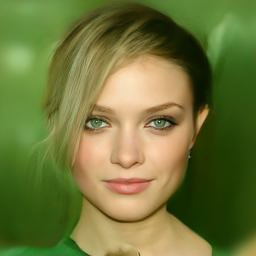

In [10]:
from PIL import Image
import numpy as np

# Convert the denoised output to an image
# Normalize the image data: values in [0,1], not [-1,1]
image = (input / 2 + 0.5).clamp(0, 1).squeeze()
# Change the shape and type for image conversion
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
# Create a PIL image
image = Image.fromarray(image)
# Display
image


In [11]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# Stable Diffusion v1.4 is used here
# It consists of several models:
# - A text encoder
# - A UNet for denoising
# - A VAE for expanding the denoised image
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True)


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

### Use a Different Scheduler

Instead of the default `PNDMScheduler`, let's use the `UniPCMultistepScheduler`:

In [12]:
from diffusers import UniPCMultistepScheduler

# Instead of the default PNDMScheduler, let's use the UniPCMultistepScheduler
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")


scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

### Move Models to GPU

To speed up inference, move the models to a GPU:

In [13]:
# Move Models to GPU
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

### Create Text Embeddings

Tokenize the text to generate embeddings. The text is used to condition the UNet model and steer the diffusion process towards something that resembles the input prompt:

In [14]:
torch.cuda.is_available()

True

In [15]:
# Parameters: prompt, sizes, etc.
prompt = ["a photo of a red planet"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance

In [16]:
# Seed generator to create the initial latent noise
generator = torch.manual_seed(0)

In [17]:
batch_size = len(prompt)

text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Tokenization of Unconditional Guidance
# Tokenizing empty prompts for unconditional guidance
# is a technique used in diffusion models,
# particularly in text-to-image generation models like Stable Diffusion.
# It involves providing the model with a set of inputs
# that do not contain any specific information or prompts.
# This helps the model learn the underlying structure or distribution
# of the data without being influenced by specific input text.
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


### Create Random Noise

Generate some initial random noise as a starting point for the diffusion process:

In [18]:
# Generate some initial random noise
latents = torch.randn((batch_size, unet.config.in_channels, height // 8, width // 8), device=torch_device)
latents = latents * scheduler.init_noise_sigma


### Denoise the Image

Create the denoising loop to progressively transform the pure noise in latents to an image described by your prompt:

In [19]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)
# Create the denoising loop to progressively transform
# the pure noise in latents to an image described by your prompt
for t in tqdm(scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, t, latents).prev_sample


  0%|          | 0/25 [00:00<?, ?it/s]

### Decode the Image

Finally, use the VAE to decode the latent representation into an image:

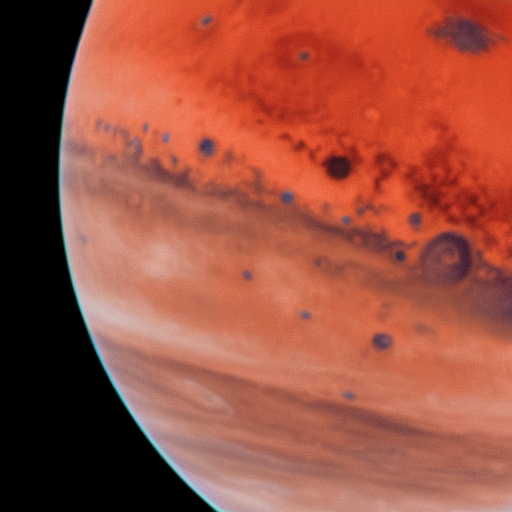

In [20]:
# Use the VAE to decode the latent representation into an image
latents = 1/ 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
# Display
image


And that's it! You've now created and understood a diffusion system using the `diffusers` library, both for a basic and a Stable Diffusion pipeline. Feel free to experiment with different models and settings to see what other amazing images you can generate!
